In [1]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader, Subset, random_split
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

import wandb
from tqdm.notebook import tqdm


## cuda check

In [2]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()
display(train_on_gpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True

## Load CIFAR10 dataset

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

## WandB login

In [4]:
wandb.login()

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: floowbaumgartner (floow-fhnw). Use `wandb login --relogin` to force relogin


True

## EDA

In [5]:
#TODO skip (discussed with martin)

# overfitting a single batch

In [6]:
#get one batch of data but in the same label for easier overfitting
overfit_label = 1
num_samples = 1

images_same_label = []

for img, label in trainset:
    if label == overfit_label:
        images_same_label.append(img)
    if len(images_same_label) == num_samples:
        break
        
images_overfit = torch.stack(images_same_label)

images_overfit.shape

torch.Size([1, 3, 32, 32])

## forward process (Noise sheduler)

the goal is to sample an image at a timestamp t and deliver it to the model. this makes the training much easier and smoother as the model can learn to denoise the image at each timestep, compared to sequently iterating over the same image over and over again. 

In [7]:
def linear_beta_schedule(timesteps, start=0.0001, end=0.02):
    """
    Create a linear beta schedule for the diffusion model. it is used to calculate the noise level at each timestep.
    """
    return torch.linspace(start, end, timesteps)

def get_index_from_list(vals, t, x_shape):
    """ 
    Returns a specific index t of a passed list of values vals
    while considering the batch dimension. (helperfunction)
    """
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

def forward_diffusion_sample(x_0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod,device="gpu"):
    """ 
    Takes an image and a timestep as input and 
    returns the noisy version of it
    """
    noise = torch.randn_like(x_0) #sample noise
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x_0.shape
    )
    # mean + variance
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) \
    + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

def precompute_terms(betas):
    """
    Precomputes terms required to calculate the noisy version of an image
    """
    alphas = 1. - betas
    alphas_cumprod = torch.cumprod(alphas, axis=0)
    alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
    sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
    sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
    sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
    posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

    return {
        "alphas": alphas,
        "alphas_cumprod": alphas_cumprod,
        "alphas_cumprod_prev": alphas_cumprod_prev,
        "sqrt_recip_alphas": sqrt_recip_alphas,
        "sqrt_alphas_cumprod": sqrt_alphas_cumprod,
        "sqrt_one_minus_alphas_cumprod": sqrt_one_minus_alphas_cumprod,
        "posterior_variance": posterior_variance
    }

tensor(-0.0065) tensor(0.9924)
tensor(0.) tensor(0.9924)
tensor(-0.2838) tensor(1.2949)
tensor(0.) tensor(1.)
tensor(-0.6647) tensor(1.4290)
tensor(0.) tensor(1.)
tensor(-0.6726) tensor(1.9736)
tensor(0.) tensor(1.)
tensor(-1.1282) tensor(1.9851)
tensor(0.) tensor(1.)


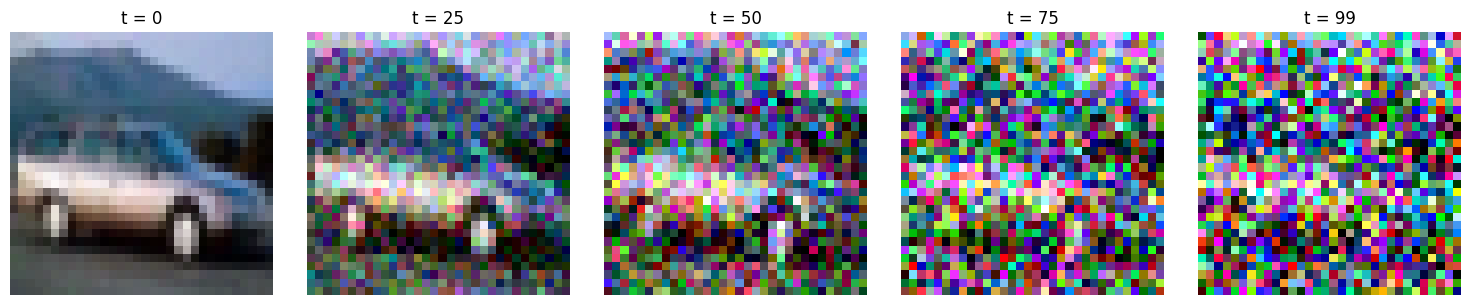

In [8]:
# time steps
T = 100
# create beta schedule
betas = linear_beta_schedule(timesteps=T)
# precompute terms
terms = precompute_terms(betas)
# define timesteps for visualization
timesteps_to_sample = [0, 25, 50, 75, 99]

# ectract single overfit image
x_0 = images_overfit[0].unsqueeze(0) # shape: (1, C, H, W)

# Generate noisy samples at the selected timesteps
noisy_images = []
for t_val in timesteps_to_sample:
    t_tensor = torch.tensor([t_val], dtype=torch.long)
    noisy_img, _ = forward_diffusion_sample(
        x_0, 
        t_tensor, 
        terms["sqrt_alphas_cumprod"], 
        terms["sqrt_one_minus_alphas_cumprod"], 
        device="cpu"
    )
    noisy_images.append(noisy_img[0]) # Remove batch dimension

# Helper function to denormalize and convert tensor for plotting
def denormalize_and_to_numpy(tensor_image):
    """
    Denormalizes and converts a tensor image to numpy for plotting.(helperfunction)
    """
    # The original transform was Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),
    # therefore apply the inverse transform: image * 0.5 + 0.5
    image = tensor_image.clone().detach()
    image = image * 0.5 + 0.5
    # Clamp to [0,1] just to be safe (because of the noise it could happen, that values are slightly outside this range)
    print(image.min(), image.max())
    image = image.clamp(0,1)
    print(image.min(), image.max())
    # Convert from Channels,Hight,Width (C,H,W) to H,W,C and to numpy
    image_np = image.permute(1,2,0).cpu().numpy()
    return image_np


# Plot the original and noisy samples
fig, axes = plt.subplots(1, len(timesteps_to_sample), figsize=(15, 3))
for ax, img, t in zip(axes, noisy_images, timesteps_to_sample):
    ax.imshow(denormalize_and_to_numpy(img))
    ax.set_title(f"t = {t}")
    ax.axis("off")

plt.tight_layout()
plt.show()

## Simple Diffusion

In [9]:
class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp =  nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2*in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
            
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu  = nn.ReLU()

    def forward(self, x, t):
        # First Conv
        h = self.bnorm1(self.relu(self.conv1(x)))
        # Time embedding
        time_emb = self.relu(self.time_mlp(t))
        # Extend last 2 dimensions
        time_emb = time_emb[(..., ) + (None, ) * 2]
        # Add time channel
        h = h + time_emb
        # Second Conv
        h = self.bnorm2(self.relu(self.conv2(h)))
        # Down or Upsample
        return self.transform(h)
    
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        # TODO: Double check the ordering here
        return embeddings

In [10]:
class SimpleUnet(nn.Module):
    """
    A simple variant of the Unet architecture.
    """
    def __init__(self):
        super().__init__()
        image_channels = 3
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 3 
        time_emb_dim = 32

        # Time embedding
        self.time_mlp = nn.Sequential(
                SinusoidalPositionEmbeddings(time_emb_dim),
                nn.Linear(time_emb_dim, time_emb_dim),
                nn.ReLU()
            )
        
        # Initial projection
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)

        # Downsample
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i+1], \
                                    time_emb_dim) \
                    for i in range(len(down_channels)-1)])
        # Upsample
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i+1], \
                                        time_emb_dim, up=True) \
                    for i in range(len(up_channels)-1)])
        # Output
        #self.output = nn.Conv2d(up_channels[-1], out_dim, 1) TODO: Check if new is correct
        self.output = nn.Sequential(
            nn.Conv2d(up_channels[-1], out_dim, 1),
            nn.Tanh()
        )


    def forward(self, x, timestep):
        # Embedd time
        t = self.time_mlp(timestep)
        # Initial conv
        x = self.conv0(x)
        # Unet
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            # Add residual x as additional channels
            x = torch.cat((x, residual_x), dim=1)           
            x = up(x, t)
        return self.output(x)

In [11]:
model = SimpleUnet()
print("Num params: ", sum(p.numel() for p in model.parameters()))
model

Num params:  62438883


SimpleUnet(
  (time_mlp): Sequential(
    (0): SinusoidalPositionEmbeddings()
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): ReLU()
  )
  (conv0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (downs): ModuleList(
    (0): Block(
      (time_mlp): Linear(in_features=32, out_features=128, bias=True)
      (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transform): Conv2d(128, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bnorm1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bnorm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
    )
    (1): Block(
      (time_mlp): Linear(in_features=32, out_features=256, bias=True)
      (conv1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (transfor

## Loss function

In [12]:
def get_loss(model, x_0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, device):
    x_noisy, noise = forward_diffusion_sample(x_0, t, sqrt_alphas_cumprod, sqrt_one_minus_alphas_cumprod, device)
    noise_pred = model(x_noisy, t)
    print("Noise predicted min/max:", noise_pred.min().item(), noise_pred.max().item())
    return F.mse_loss(noise, noise_pred)

 tried l1_loss and now mse_loss

## sampling

In [13]:
@torch.no_grad() # to prevent memory out of bounds
def sample_timestep(x, t,sqrt_one_minus_alphas_cumprod, sqrt_recip_alphas, betas, model, posterior_variance):
    """
    Calls the model to predict the noise in the image and returns 
    the denoised image. 
    Applies noise to this image, if we are not in the last step yet.
    """
    betas_t = get_index_from_list(betas, t, x.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(
        sqrt_one_minus_alphas_cumprod, t, x.shape
    )
    sqrt_recip_alphas_t = get_index_from_list(sqrt_recip_alphas, t, x.shape)
    
    # Call model (current image - noise prediction)
    model_mean = sqrt_recip_alphas_t * (
        x - betas_t * model(x, t) / sqrt_one_minus_alphas_cumprod_t + 1e-5
    ) # 1e-5 is added to prevent division by zero
    posterior_variance_t = get_index_from_list(posterior_variance, t, x.shape)
    
    if t.item() == 0: #TODO: Check if .item this is correct
        # The t's are offset from the t's in the paper https://arxiv.org/pdf/2006.11239
        return model_mean
    else:
        noise = torch.randn_like(x)
        return model_mean + torch.sqrt(posterior_variance_t) * noise 

@torch.no_grad()
def sample_plot_image(T,sqrt_one_minus_alphas_cumprod, sqrt_recip_alphas, betas, model, posterior_variance):
    # Sample random noise
    img = torch.randn((1, 3, 32, 32), device=device)
    
    plt.figure(figsize=(15,15))
    plt.axis('off')
    num_images = 10
    stepsize = int(T/num_images)

    for i in range(0,T)[::-1]: # Iterates over T to 0, because the diffusion process goes backwards
        t = torch.full((1,), i, device=device, dtype=torch.long)
        img = sample_timestep(img, t, sqrt_one_minus_alphas_cumprod, sqrt_recip_alphas, betas, model, posterior_variance)
        #img = torch.clamp(img, -1.0, 1.0)
        if i % stepsize == 0:
            plt.subplot(1, num_images, int(i/stepsize)+1)
            print(img.min(), img.max())
            plt.imshow(denormalize_and_to_numpy(img[0]))
            plt.axis('off')
    
    plt.imshow(denormalize_and_to_numpy(img[0])) #TODO: Check if denormalize_and_to_numpy(img[0])  is correct, was img before
    plt.axis('off')
            
    plt.show()            

  0%|          | 0/1000 [00:00<?, ?it/s]

Noise predicted min/max: -0.5227223634719849 0.6078364849090576
Epoch 0 Loss: 1.0228559970855713
Noise predicted min/max: -0.5124890804290771 0.548132061958313
Noise predicted min/max: -0.5015242695808411 0.6518154144287109
Noise predicted min/max: -0.5142377614974976 0.5830954313278198
Noise predicted min/max: -0.5538800954818726 0.612190306186676
Noise predicted min/max: -0.5222828388214111 0.658257007598877
Noise predicted min/max: -0.5965335369110107 0.552943229675293
Noise predicted min/max: -0.5079392194747925 0.5554572343826294
Noise predicted min/max: -0.5674490332603455 0.6150485277175903
Noise predicted min/max: -0.5298461318016052 0.5889594554901123
Noise predicted min/max: -0.565873920917511 0.5204985737800598
Noise predicted min/max: -0.5133501887321472 0.5205574631690979
Noise predicted min/max: -0.46568357944488525 0.5400635004043579
Noise predicted min/max: -0.5521653294563293 0.5797786712646484
Noise predicted min/max: -0.5235275626182556 0.6317653059959412
Noise predi

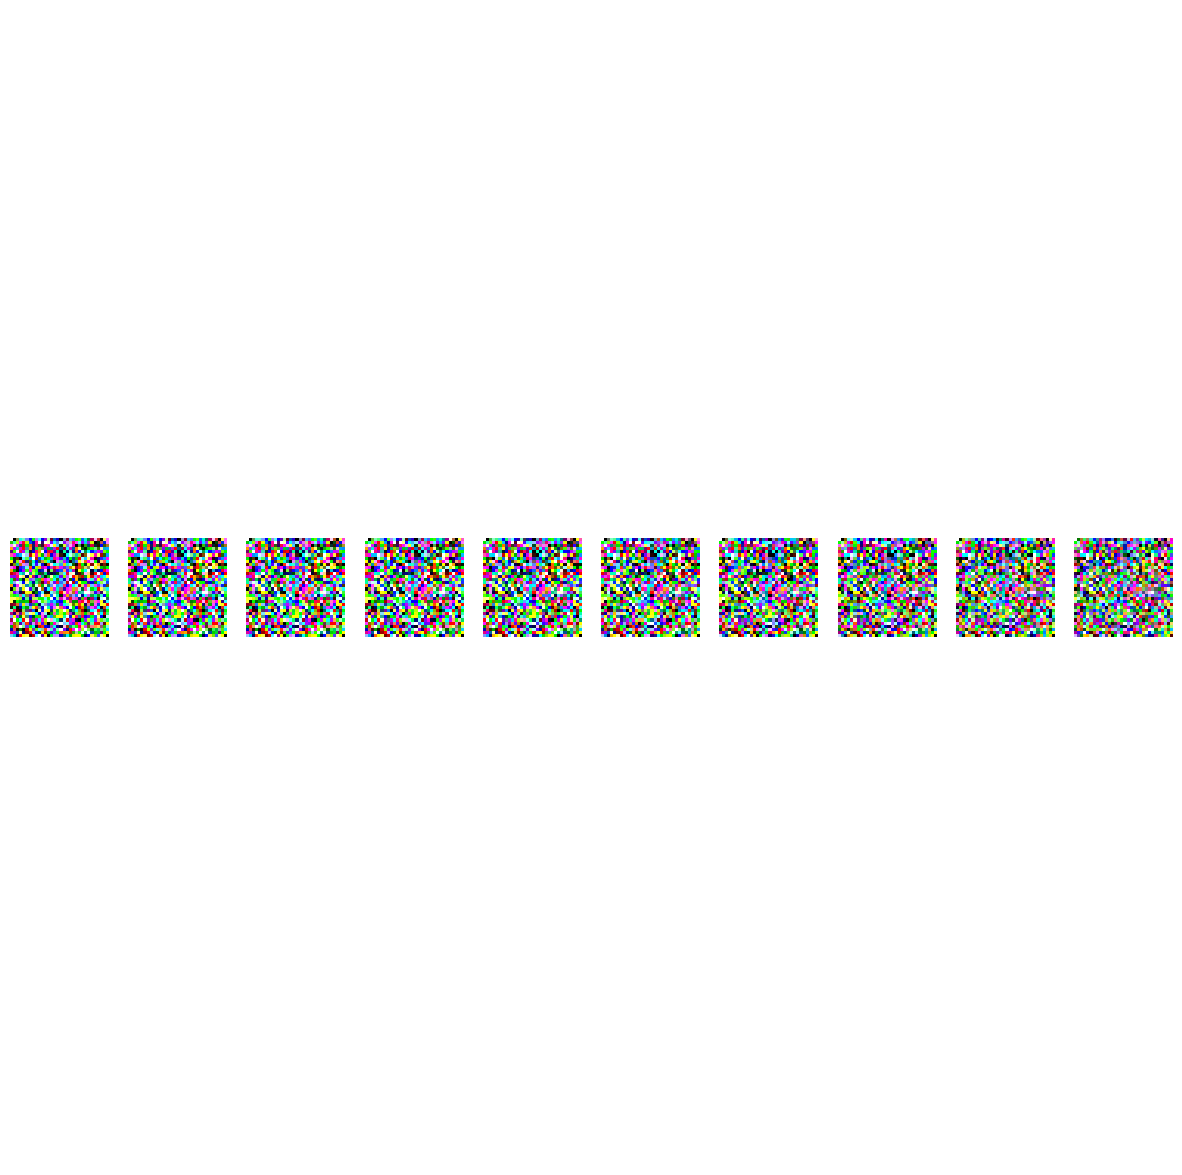

Noise predicted min/max: -0.7941467761993408 0.7838895320892334
Noise predicted min/max: -0.7662949562072754 0.7750864624977112
Noise predicted min/max: -0.9173133373260498 0.8984428644180298
Noise predicted min/max: -0.9249897003173828 0.9248064160346985
Noise predicted min/max: -0.8514418601989746 0.8888189792633057
Noise predicted min/max: -0.9345037341117859 0.9323635697364807
Noise predicted min/max: -0.9586255550384521 0.9443606734275818
Noise predicted min/max: -0.9149584770202637 0.9292393326759338
Noise predicted min/max: -0.9003291130065918 0.9746975898742676
Noise predicted min/max: -0.8743693828582764 0.8597006797790527
Noise predicted min/max: -0.9506934285163879 0.969760537147522
Noise predicted min/max: -0.9406170845031738 0.9510292410850525
Noise predicted min/max: -0.9360048174858093 0.9362475275993347
Noise predicted min/max: -0.9443119168281555 0.9434149861335754
Noise predicted min/max: -0.9461284279823303 0.9188590049743652
Noise predicted min/max: -0.9727300405502

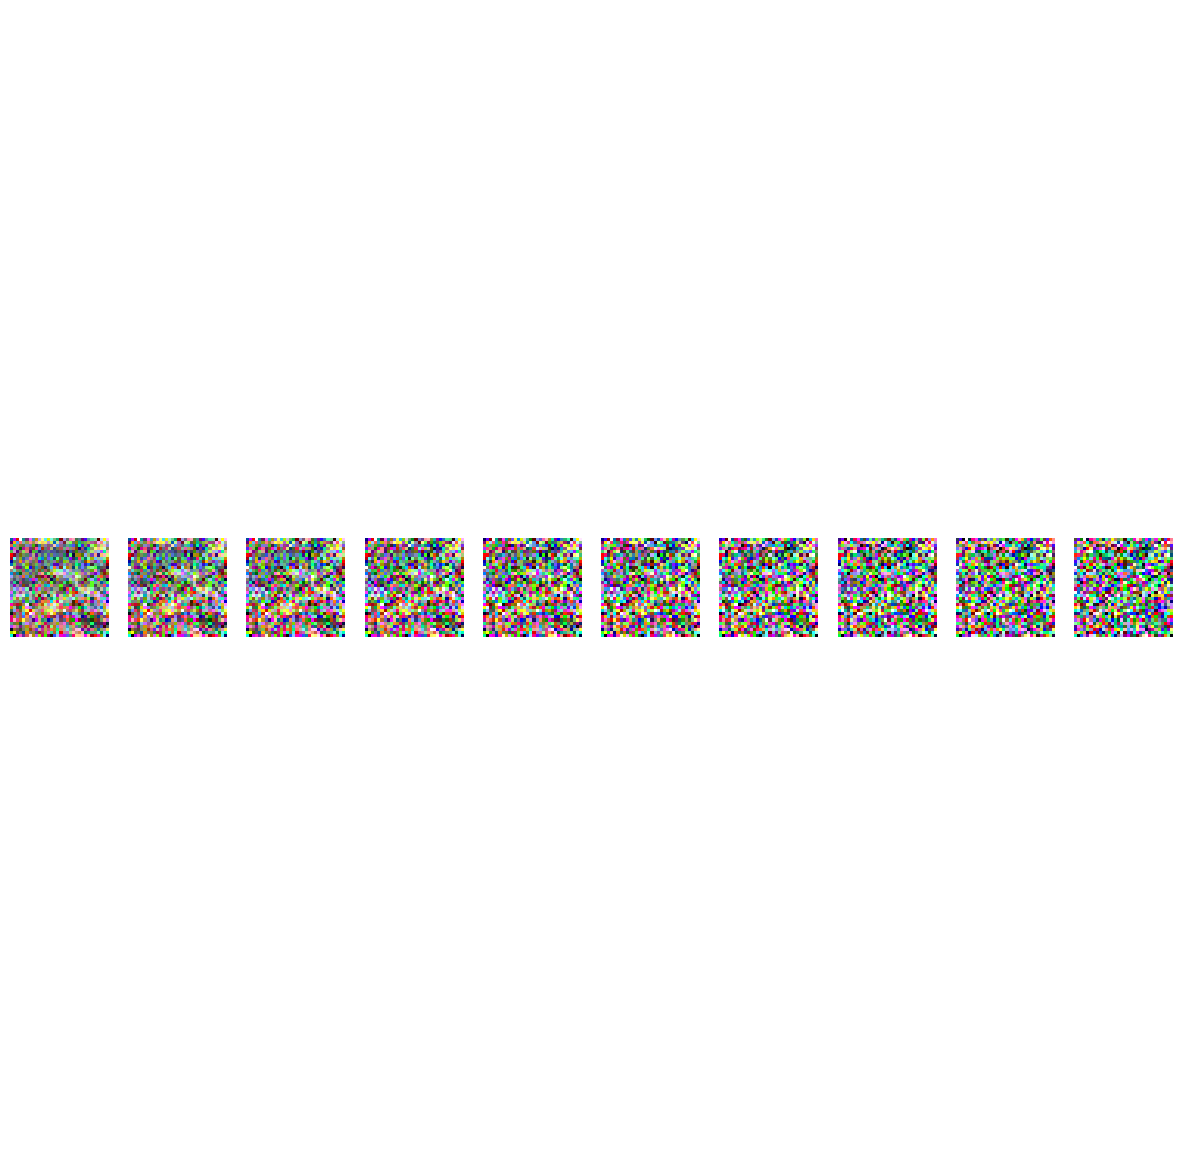

Noise predicted min/max: -0.9998952746391296 0.9999727606773376
Noise predicted min/max: -0.9997677206993103 0.999842643737793
Noise predicted min/max: -0.999909520149231 0.9999213814735413
Noise predicted min/max: -0.9999432563781738 0.9999613165855408
Noise predicted min/max: -0.9998894333839417 0.9999638199806213
Noise predicted min/max: -0.9998813271522522 0.9999747276306152
Noise predicted min/max: -0.9999600648880005 0.999958872795105
Noise predicted min/max: -0.9999544620513916 0.9999342560768127
Noise predicted min/max: -0.9999879002571106 0.9999762773513794
Noise predicted min/max: -0.9999880790710449 0.9999670386314392
Noise predicted min/max: -0.9999669194221497 0.999925971031189
Noise predicted min/max: -0.9999123215675354 0.9999397397041321
Noise predicted min/max: -0.999893307685852 0.9999865293502808
Noise predicted min/max: -0.9999203085899353 0.9999869465827942
Noise predicted min/max: -0.9999538660049438 0.9999896287918091
Noise predicted min/max: -0.9999726414680481 

In [14]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 1000
BATCH_SIZE = 1
T = 100

for epoch in tqdm(range(epochs)):
    optimizer.zero_grad()
    t = torch.randint(0, T, (BATCH_SIZE,), device=device).long()
    loss = get_loss(model, images_overfit, t, terms["sqrt_alphas_cumprod"], terms["sqrt_one_minus_alphas_cumprod"], device)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch} Loss: {loss.item()}")
        if epoch in {10, 100, 900, 1000, 9900}:
            sample_plot_image(T,terms["sqrt_one_minus_alphas_cumprod"], terms["sqrt_recip_alphas"], betas, model, terms["posterior_variance"])
        

NameError: name 'noise_pred' is not defined

In [ ]:
sample_plot_image(T,terms["sqrt_one_minus_alphas_cumprod"], terms["sqrt_recip_alphas"], betas, model, terms["posterior_variance"])

fragen:
- parameter optimierung?
- mehrere aktivierungsfunktionen testen, oder die besten verwenden und weiterfahren?
- mehrere lossfunctions austesten?
- conditional -> 3 klassen genug?
diagnostische plots -> wandb
- wie testen -> qualität eines generativen modells testen